# Churn prediction

> Para esto es mejor usar pipelines, ayuda a hacerlo más rápido.

Importamos librerias

In [251]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
df = pd.read_csv('data/Churn.csv')
df.shape

(7043, 21)

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Limpiamos ciertos datos, `TotalCharges` no dejaba cambiarlo a float, por lo que tocó revisar y cambiar los espacios por 0

In [254]:
df = df.drop(columns=['customerID'])
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [255]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [256]:
df.isnull().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

## EDA

Esto si lo necesitamos podemos hacerlo de una vez en lugar de esperar a la parte del encoding

In [257]:
df['churn'] = df['churn'].map({"No": 0, "Yes": 1})

`normalize=True` me muestra los porcentajes en lugar de cuantos valores hay, por lo que es más visible, por ejemplo, el 73% de las personas no abandonaron (está como que algo desbalanceado)

In [258]:
df.churn.value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [259]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

## Feature importance: mutual information

Esta parte se hizo para ver la importancia de las variables, nada que afecte al código, solo visual.

In [260]:
def get_cat_cols(df, exclude=None):
    if exclude:
        return df.select_dtypes(include=['object']).columns.drop(exclude)
    else:
        return df.select_dtypes(include=['object']).columns

def get_num_cols(df, exclude=None):
    if exclude:
        return df.select_dtypes(include=['number']).columns.drop(exclude)
    else:
        return df.select_dtypes(include=['number']).columns

In [261]:
# No me funcionaba cuando usaba una variable con altisima cardinaliad, era la del id
def calculate_mi(series):
    return mutual_info_score(series, df.churn)

mi = df[get_cat_cols(df)].apply(calculate_mi)
mi.sort_values(ascending=False)

contract            0.098453
onlinesecurity      0.064677
techsupport         0.063021
internetservice     0.055574
onlinebackup        0.046792
paymentmethod       0.044519
deviceprotection    0.043917
streamingmovies     0.032001
streamingtv         0.031908
paperlessbilling    0.019194
dependents          0.014467
partner             0.011454
multiplelines       0.000801
phoneservice        0.000072
gender              0.000037
dtype: float64

## Feature importance: Correlation

In [262]:
df[get_num_cols(df)].corrwith(df.churn)

seniorcitizen     0.150889
tenure           -0.352229
monthlycharges    0.193356
totalcharges     -0.198324
churn             1.000000
dtype: float64

Como churn está en 0 y 1, al calcular el ``mean()`` me ayuda a ver la relación que tienen, en este caso indica que el 58% de las personas con 2 meses o menos de permanencia se dieron de baja.

In [263]:
df[df.tenure <= 2].churn.mean()

np.float64(0.5835266821345708)

In [264]:
df[df.tenure > 2].churn.mean()

np.float64(0.22099983821388125)

## Encoding

Las variables con Yes y No, las voy a tratar con map, el esto con one hot

In [265]:
df['partner'] = df['partner'].map({"No": 0, "Yes": 1})
df['dependents'] = df['dependents'].map({"No": 0, "Yes": 1})
df['phoneservice'] = df['phoneservice'].map({"No": 0, "Yes": 1})
df['paperlessbilling'] = df['paperlessbilling'].map({"No": 0, "Yes": 1})

In [266]:
columns_to_encoding = df.select_dtypes(exclude=['number']).columns

onehot = OneHotEncoder(sparse_output=False)
df_encoding = onehot.fit_transform(df[columns_to_encoding])
df_encoding = pd.DataFrame(df_encoding, columns=onehot.get_feature_names_out(columns_to_encoding))
new_df = pd.concat([df, df_encoding], axis=1).drop(columns=columns_to_encoding, axis=1)

In [267]:
new_df.shape

(7043, 42)

## Split

el split será de 60, 40

In [268]:
X = new_df.drop('churn', axis=1).copy()
y = new_df['churn'].copy()

In [269]:
x_train, x_rest, y_train, y_rest = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42, stratify=y_rest)

print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print("Tamaño del conjunto de validación:", x_valid.shape)
print("Tamaño del conjunto de prueba:", x_test.shape)

Tamaño del conjunto de entrenamiento: (4225, 41)
Tamaño del conjunto de validación: (1409, 41)
Tamaño del conjunto de prueba: (1409, 41)


## Feature scaling

In [270]:
# elimino las categóricas o binarias, solo para visualizar
x_train[get_num_cols(df, exclude=['churn','partner','dependents','phoneservice','seniorcitizen','paperlessbilling'])].describe()

,tenure,monthlycharges,totalcharges
count,4225.000000,4225.000000,4225.000000
mean,32.442840,64.894509,2295.489408
std,24.629184,30.326002,2287.797684
min,0.000000,18.400000,0.000000
25%,9.000000,35.400000,399.600000
50%,29.000000,70.550000,1372.450000
75%,55.000000,90.100000,3862.550000
max,72.000000,118.750000,8684.800000


In [271]:
scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_valid_scaled = x_valid.copy()

x_train_scaled[['tenure', 'monthlycharges', 'totalcharges']] = scaler.fit_transform(x_train_scaled[['tenure','monthlycharges','totalcharges']])
x_valid_scaled[['tenure', 'monthlycharges', 'totalcharges']] = scaler.transform(x_valid_scaled[['tenure','monthlycharges','totalcharges']])

# verificando que siga el mismo tamaño, al parecer si
print(x_train_scaled.shape)

(4225, 41)


también voy a escalar test para probarlo de una vez abajo

In [272]:
x_test_scaled = x_test.copy()

x_test_scaled[['tenure', 'monthlycharges', 'totalcharges']] = scaler.transform(x_test_scaled[['tenure','monthlycharges','totalcharges']])

## Model

In [273]:
model = LogisticRegression()
model.fit(x_train_scaled, y_train)

LogisticRegression()

In [274]:
val_pred = model.predict(x_valid_scaled)
val_pred_proba = model.predict_proba(x_valid_scaled)[:,1]

In [275]:
print(f'Accuracy val: {accuracy_score(y_valid, val_pred)}')
print(f'Accuracy val: {((val_pred_proba >= 0.5) == y_valid).mean()}')

Accuracy val: 0.8218594748048261
Accuracy val: 0.8218594748048261


## Model testing

> Recordar que para probarlo hay que hacerle las mismas transformaciones, por eso hacerlo con ***pipelines*** es más facil para las del conjunto de pruebas, en este caso test.

In [276]:
df_x = pd.concat([x_train,x_valid])
df_y = pd.concat([y_train, y_valid])    

In [277]:
test_pred = model.predict(x_test_scaled)
print(f'Accuracy test: {accuracy_score(y_test, test_pred)}')

Accuracy test: 0.7849538679914834


## Evaluation metrics

### Accuracy

El accuracy nos dice los true positives, y true negatives, es decir, me dice la cantidad de predicciones correctas en general

In [278]:
(y_valid == (val_pred_proba>=0.5)).mean()

np.float64(0.8218594748048261)

Pero el problema es que el dataset está bastante desbalanceado, el 73% de los datos está como que no abandonó, y un 26% que abandonó.

In [279]:
1 - y_valid.mean()

np.float64(0.7345635202271115)

In [280]:
(y_valid == (val_pred_proba==1)).mean()

np.float64(0.7345635202271115)

### Confusion table

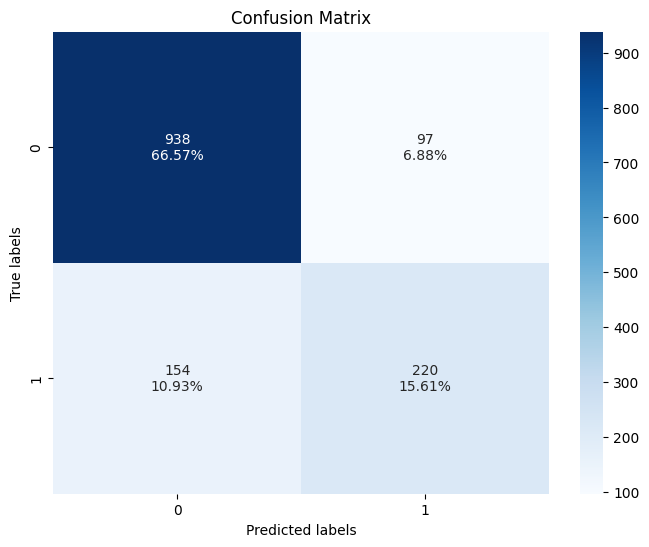

In [288]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, model.predict(x_valid_scaled))
names = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{name}\n{percentage}' for name, percentage in zip(names,percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Precision and recall

La precisión me dice cuantas correctas son correctas, o sea los true positives, el recall los true negatives

In [283]:
p = precision_score(y_valid, model.predict(x_valid_scaled))
p

np.float64(0.694006309148265)

In [284]:
r = recall_score(y_valid, model.predict(x_valid_scaled))
r

np.float64(0.5882352941176471)